In [1]:
from __future__ import print_function, division, absolute_import

import GPy
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
from torch.utils.data import Dataset, DataLoader
import safeopt
import torch

%load_ext autoreload
%autoreload 2

from neural_process import NeuralProcess

import random
from training import *
from agents import *
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


mpl.rcParams['figure.figsize'] = (20.0, 10.0)
mpl.rcParams['font.size'] = 20
mpl.rcParams['lines.markersize'] = 20


In [2]:
# Measurement noise
noise_var = 0.01 ** 2

# Bounds on the inputs variable
bounds = [(-2., 2.)]
parameter_set = safeopt.linearly_spaced_combinations(bounds, 100)

# Define Kernel
kernel = GPy.kern.RBF(input_dim=len(bounds), variance=0.5, lengthscale=0.7, ARD=True)

# Initial safe point
x0 = np.zeros((1, len(bounds)))

# Generate function with safe initial point at x=0
def sample_safe_fun():
    fun = safeopt.sample_gp_function(kernel, bounds, noise_var, 100)
    return fun

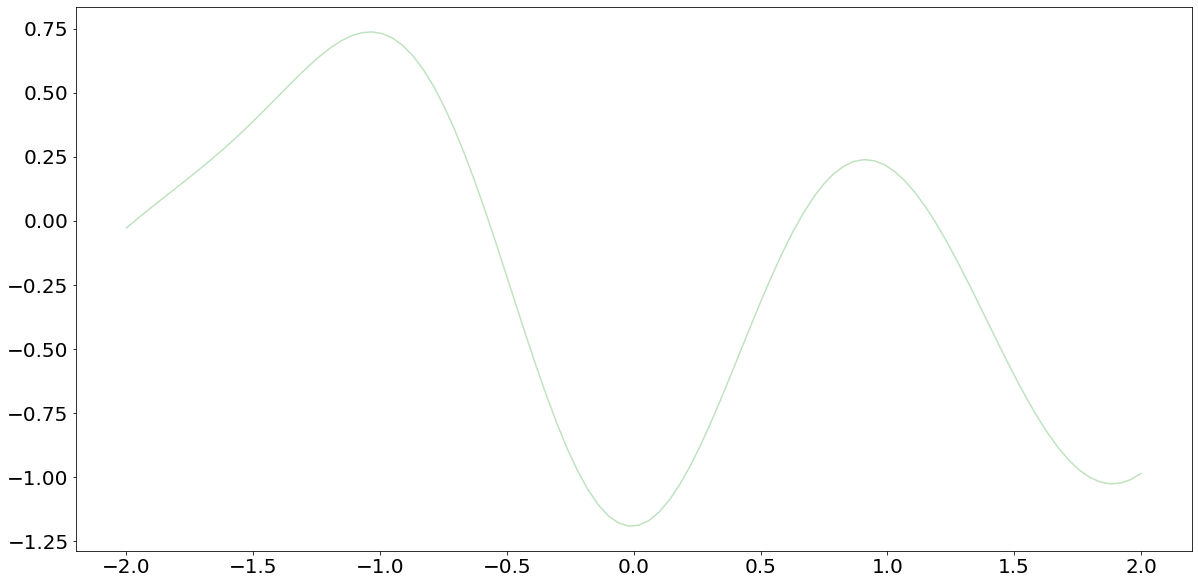

In [3]:
fun = sample_safe_fun()

def plot_gp():
    # Plot the GP
#     opt.plot(1000)
    # Plot the true function
    plt.plot(parameter_set, fun(parameter_set, noise=False), color='C2', alpha=0.3)
    
plot_gp()

In [4]:
class RegressionDataset(Dataset):
    
    def __init__(self, sample_func, parameter_set, num_function=1000):
        self.parameter_set = parameter_set
        self.num_function = num_function
        self.sample_func = sample_func
    
    def __len__(self):
        return self.num_function
    
    def __getitem__(self, idx):
        func = self.sample_func()
        return torch.from_numpy(self.parameter_set).float(), torch.from_numpy(func(self.parameter_set)).float()
        
        

In [5]:
dataset = RegressionDataset(sample_safe_fun, parameter_set)

In [6]:
x_dim = 1
y_dim = 1
r_dim = 128  # Dimension of representation of context points
z_dim = 128  # Dimension of sampled latent variable
h_dim = 128  # Dimension of hidden layers in encoder and decoder

neuralprocess = NeuralProcess(x_dim, y_dim, r_dim, z_dim, h_dim)

In [7]:
neuralprocess

NeuralProcess(
  (xy_to_r): Encoder(
    (input_to_hidden): Sequential(
      (0): Linear(in_features=2, out_features=128, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): ReLU(inplace=True)
      (4): Linear(in_features=128, out_features=128, bias=True)
      (5): ReLU(inplace=True)
      (6): Linear(in_features=128, out_features=128, bias=True)
      (7): ReLU(inplace=True)
      (8): Linear(in_features=128, out_features=128, bias=True)
    )
  )
  (r_to_mu_sigma): MuSigmaEncoder(
    (r_to_hidden): Linear(in_features=128, out_features=128, bias=True)
    (hidden_to_mu): Linear(in_features=128, out_features=128, bias=True)
    (hidden_to_sigma): Linear(in_features=128, out_features=128, bias=True)
  )
  (xz_to_y): Decoder(
    (xz_to_hidden): Sequential(
      (0): Linear(in_features=129, out_features=128, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3

In [8]:
from torch.utils.data import DataLoader
from training import NeuralProcessTrainer

batch_size = 1
num_context = 20
num_target = 20

data_loader = DataLoader(dataset, batch_size=batch_size)
it = iter(data_loader)
optimizer = torch.optim.Adam(neuralprocess.parameters(), lr=1e-4)
np_trainer = NeuralProcessTrainer(device, neuralprocess, optimizer,
                                  num_context_range=(num_context, num_context),
                                  num_extra_target_range=(num_target, num_target), 
                                  print_freq=200)

neuralprocess.training = True
np_trainer.train(data_loader, 30)

iteration 200, loss 52.834
iteration 400, loss 44.323
iteration 600, loss 77.689
iteration 800, loss 37.723
iteration 1000, loss 19.608
Epoch: 0, Avg_loss: 39.73947281360626
iteration 1200, loss 76.043
iteration 1400, loss 29.769
iteration 1600, loss 32.047
iteration 1800, loss 57.270
iteration 2000, loss 80.587
Epoch: 1, Avg_loss: 34.59216230487824
iteration 2200, loss 22.706
iteration 2400, loss 92.393
iteration 2600, loss 26.606
iteration 2800, loss 32.660
iteration 3000, loss 30.148
Epoch: 2, Avg_loss: 34.99709970283509
iteration 3200, loss 56.798
iteration 3400, loss 20.635
iteration 3600, loss 38.502
iteration 3800, loss 27.937
iteration 4000, loss 23.288
Epoch: 3, Avg_loss: 34.81175442028046
iteration 4200, loss 40.249
iteration 4400, loss 48.832
iteration 4600, loss 32.053
iteration 4800, loss 66.105
iteration 5000, loss 48.682
Epoch: 4, Avg_loss: 35.01867916584015
iteration 5200, loss 45.046
iteration 5400, loss 30.722
iteration 5600, loss 50.509
iteration 5800, loss 13.753
it

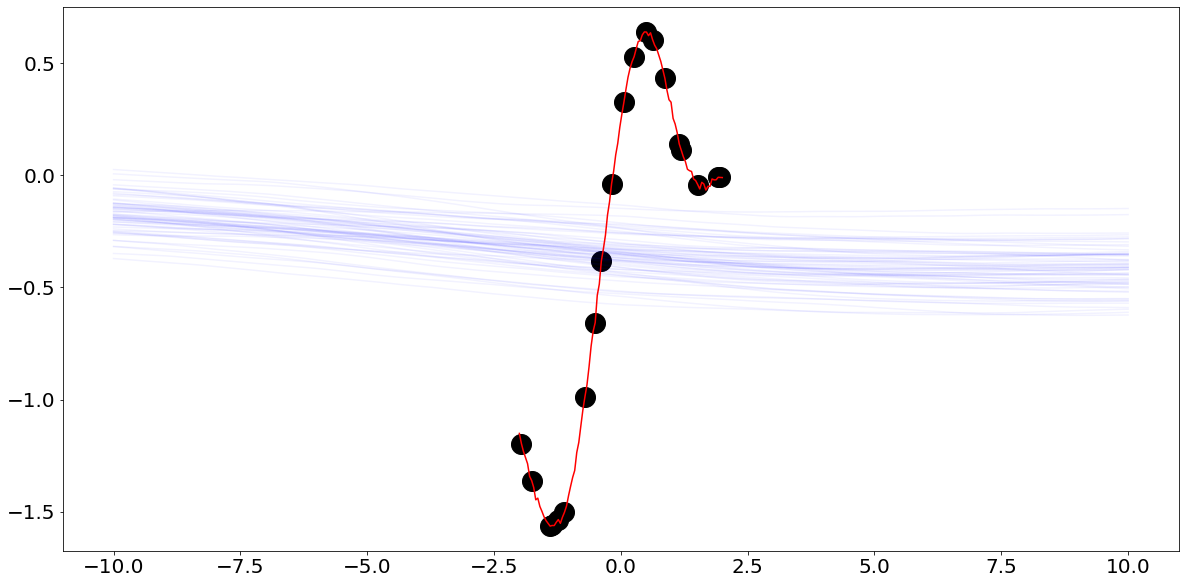

In [147]:
from utils import context_target_split

# Extract a batch from data_loader
for batch in data_loader:
    break

# Use batch to create random set of context points
x, y = next(it)
x, y = x[0:1], y[0:1]
x_context, y_context, _, _ = context_target_split(x[0:1], y[0:1], 
                                                  num_context, 
                                                  num_target)
x_context, y_context = x_context.float(), y_context.float()
# Create a set of target points corresponding to entire [-pi, pi] range
x_target = torch.Tensor(np.linspace(-10, 10, 100)).float()
x_target = x_target.unsqueeze(1).unsqueeze(0)

neuralprocess.training = False

for i in range(64):
    # Neural process returns distribution over y_target
    p_y_pred = neuralprocess(x_context, y_context, x_target)
    # Extract mean of distribution
    mu = p_y_pred.loc.detach()
    plt.plot(x_target.numpy()[0], mu.numpy()[0], 
             alpha=0.05, c='b')

plt.plot(x.numpy().squeeze(), y.numpy().squeeze(), c='r')
plt.scatter(x_context[0].numpy(), y_context[0].numpy(), c='k')